# PyTorch tutorial 2 — losses, optimizers, and a small AO example

This notebook continues from the basic PyTorch introduction (tensors, autograd, computation graphs) and moves toward **training loops** and **small neural networks**.

We will:
1. Review why the **loss must be a scalar** for `loss.backward()`.
2. See the most common **loss functions** in PyTorch.
3. Implement **manual gradient descent** and then the same thing with **PyTorch optimizers** (SGD, Momentum, Adam).
4. Introduce **Dataset** and **DataLoader** to feed data in mini-batches.
5. Finish with a **tip–tilt regression** example using **synthetic PSF images** (AO-flavoured).

## Learning objectives

By the end of this section you will be able to:

1. Define an appropriate **loss** for a task and explain why it must be **scalar** for `loss.backward()`.
2. Implement **gradient descent** updates and compare them with **SGD/Momentum/Adam**.
3. Run the full training loop in PyTorch: **forward → loss → backward → optimizer.step() → zero_grad()**.
4. Keep **model** and **data** on the **same device** (CPU/GPU) and use `no_grad()` during evaluation.


## Loss functions: defining a scalar objective

Training in PyTorch almost always ends with a **scalar** loss — a single number that tells us “how bad” the prediction was. That scalar is what we differentiate.

- `loss.backward()` **without arguments** only works if `loss` is a **scalar**.
- If you produce a **vector** of losses (one per example), reduce it first (e.g. `.mean()` or `.sum()`), or supply an **upstream gradient** with the same shape as the output.

The reason this works so well is that most ML tasks boil down to:
> predictions → compare with targets → reduce to **one** number → differentiate.


### Common losses you’ll use

- **Regression**
  - `nn.MSELoss(reduction='mean')` — mean squared error (default).
  - `nn.L1Loss(reduction='mean')` — mean absolute error.
  - `nn.SmoothL1Loss` (Huber) — robust to outliers.

- **Binary classification**
  - `nn.BCEWithLogitsLoss` (recommended): expects **logits** (no sigmoid applied). Use `pos_weight` to handle class imbalance.
  - `nn.BCELoss`: expects **probabilities** (after `sigmoid`). *Less numerically stable* than `BCEWithLogitsLoss`.

- **Multi-class classification**
  - `nn.CrossEntropyLoss`: expects **logits** of shape `(N, C)` and **integer labels** of shape `(N,)` with dtype `torch.long`. Internally combines `log_softmax` + negative log-likelihood in a stable way.

- **Reductions**
  - `reduction='mean' | 'sum' | 'none'` controls how to obtain a **scalar** from per-element losses. With `'none'` you get a tensor of losses and then reduce it yourself (e.g. `loss_per_sample.mean()`).

- **Weighted / class imbalance**
  - Many losses accept `weight` (per-class weights) or `pos_weight` (for positive class in binary tasks) to adjust contributions when classes are imbalanced.

### Typical shape/dtype gotchas

- **CrossEntropyLoss**: `logits` → `(N, C)` (float), `targets` → `(N,)` (long). Do **not** apply `softmax`/`log_softmax` beforehand.
- **BCEWithLogitsLoss**: `logits` → `(N, 1)` or `(N,)`, `targets` → float in `[0, 1]`. Do **not** apply `sigmoid` beforehand.
- **MSE/L1**: `pred` and `target` must have the **same shape** and floating dtype.


In [16]:
# 1) Regression: scalar loss with MSE
import torch
import torch.nn as nn

# fake batch (N=4)
pred = torch.tensor([[2.5],[0.0],[1.5],[3.2]], dtype=torch.float32)
target = torch.tensor([[3.0],[0.5],[1.0],[3.0]], dtype=torch.float32)

loss_fn = nn.MSELoss(reduction="mean")  # returns a scalar by default
loss = loss_fn(pred, target)            # scalar
print("MSE loss (scalar):", loss.item())


MSE loss (scalar): 0.19750000536441803


In [17]:
# 2) Multi-class classification: CrossEntropyLoss
import torch
import torch.nn as nn

# logits: shape (N, C); labels: shape (N,) with dtype long
logits = torch.tensor([[ 1.2, -0.3,  0.1],
                       [-0.5,  2.0,  0.3],
                       [ 0.7,  0.1, -1.2]], dtype=torch.float32, requires_grad=True)  # N=3, C=3
labels = torch.tensor([0, 1, 2], dtype=torch.long)  # correct class indices

ce = nn.CrossEntropyLoss()   # reduction='mean' by default → scalar
loss = ce(logits, labels)
print("Cross-entropy loss (scalar):", loss.item())

loss.backward()
print("logits.grad shape:", logits.grad.shape)  # (N, C)


Cross-entropy loss (scalar): 1.035561203956604
logits.grad shape: torch.Size([3, 3])


### Per-sample losses and multiple `backward()`

Sometimes a loss returns **one value per sample** (because we used `reduction='none'`). In that case we often:

1. **Reduce to a scalar** ourselves (e.g. `loss_per_sample.mean()`) and call `backward()` once, **or**
2. Call `backward(upstream)` providing an **upstream gradient** with the **same shape** as the output.

In the example below we do **both** on purpose to show the two ways. Because we want to call `backward()` **twice** on the **same graph**, we must use `retain_graph=True` the first time.

> In normal training you **do not** do two `backward()` on the same graph. We do it here only to show both patterns.


In [18]:
# 3) Working with per-sample losses (reduction='none') → reduce to a scalar

import torch
import torch.nn as nn

pred = torch.tensor([[0.2],[0.8],[0.5],[0.1]], dtype=torch.float32, requires_grad=True)
target = torch.tensor([[0.0],[1.0],[1.0],[0.0]], dtype=torch.float32)

mse_none = nn.MSELoss(reduction="none")      # returns per-element loss (same shape as pred)
loss_per_elem = mse_none(pred, target)       # shape (N, 1)
loss_per_sample = loss_per_elem.mean(dim=1)  # shape (N,) — mean over features per sample

# Option A (recommended): reduce to scalar and then backward
loss = loss_per_sample.mean()                # scalar over the batch
loss.backward(retain_graph=True)
print("Option A → pred.grad (shape):", pred.grad.shape)

# Option B: provide upstream gradient for vector outputs (advanced)
pred.grad = None
upstream = torch.ones_like(loss_per_sample) / loss_per_sample.numel()  # normalized weights
loss_per_sample.backward(upstream)  # same shape as loss_per_sample
print("Option B → pred.grad (shape):", pred.grad.shape)


Option A → pred.grad (shape): torch.Size([4, 1])
Option B → pred.grad (shape): torch.Size([4, 1])


## From gradients to parameter updates (manual gradient descent)

We’ll minimize a simple 1D loss:
$[ L(\theta) = (\theta - 3)^2 ]$
Autograd gives $(\nabla_\theta L = 2(\theta-3))$. We’ll update $(\theta \leftarrow \theta - \alpha \nabla_\theta L)$.

Key steps each iteration:
1. Build a **scalar** `loss` from current parameters  
2. `loss.backward()` to fill `.grad`  
3. Update parameters with the gradient (inside `torch.no_grad()`)  
4. Clear gradients before the next step


In [19]:
# Manual gradient descent on a toy 1D problem
import torch
torch.manual_seed(0)

theta = torch.tensor([0.0], requires_grad=True)  # parameter to optimize
lr = 0.1

for step in range(20):
    loss = (theta - 3.0).pow(2)       # scalar loss
    loss.backward()                   # computes dloss/dtheta into theta.grad
    
    with torch.no_grad():             # update without tracking autograd
        theta -= lr * theta.grad
    
    theta.grad = None                 # clear grad for next step
    
    if step % 5 == 0:
        print(f"step {step:02d} | theta={theta.item():.4f} | loss={loss.item():.6f}")


step 00 | theta=0.6000 | loss=9.000000
step 05 | theta=2.2136 | loss=0.966368
step 10 | theta=2.7423 | loss=0.103763
step 15 | theta=2.9156 | loss=0.011141


## Using PyTorch optimizers (SGD / Momentum / Adam)

Same loss, but let `torch.optim` handle updates and gradient bookkeeping.  
You still do: **forward → scalar loss → zero_grad() → backward() → step()**.

- **SGD**: plain gradient step. Simple, good baseline.
- **SGD + Momentum (Nesterov)**: accelerates along consistent directions and reduces zig-zag.
- **Adam / AdamW**: adaptive step per parameter using gradient moments; very robust default.


In [20]:
import torch

def run_optimizer(opt_name, steps=30, lr_sgd=0.1, lr_mom=0.05, lr_adam=1e-2):
    torch.manual_seed(0)
    theta = torch.tensor([0.0], requires_grad=True)

    if opt_name == "sgd":
        opt = torch.optim.SGD([theta], lr=lr_sgd)
    elif opt_name == "momentum":
        opt = torch.optim.SGD([theta], lr=lr_mom, momentum=0.9, nesterov=True)
    elif opt_name == "adam":
        opt = torch.optim.Adam([theta], lr=lr_adam)
    else:
        raise ValueError("opt_name ∈ {'sgd','momentum','adam'}")
    
    for step in range(steps):
        loss = (theta - 3.0).pow(2)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
    return theta.item(), loss.item()

for name in ["sgd", "momentum", "adam"]:
    th, ls = run_optimizer(name)
    print(f"{name:8} → final θ={th:.4f} | final loss={ls:.6e}")


sgd      → final θ=2.9963 | final loss=2.155047e-05
momentum → final θ=3.1244 | final loss=2.041284e-02
adam     → final θ=0.2974 | final loss=7.356979e+00


### What changes across optimizers?

- **SGD**: plain gradient step. Simple, strong baseline; learning rate matters.
- **SGD + Momentum (Nesterov)**: accumulates a velocity term to accelerate along consistent directions and reduce zig-zag.
- **Adam**: adapts the step per-parameter using first/second moment estimates of the gradients; very stable default with `lr≈1e-3`.

> In practice: start with **Adam** or **AdamW** for quick progress; try **SGD+Momentum** when you can tune LR/schedules and want potential generalization gains.


## Datasets, DataLoaders and batches

Before training a “real” model we need to formalize how data is fed to PyTorch.

- **Dataset (`torch.utils.data.Dataset`)**: Python object that knows how many samples it has (`__len__`) and how to return *one* sample (`__getitem__(i) → (x, y)`). Here we create a synthetic dataset where `y = 2.5x + 0.7 + noise`.
- **DataLoader (`torch.utils.data.DataLoader`)**: wraps a Dataset and gives you **mini-batches**.
  - `batch_size=64` → each iteration you get 64 samples stacked into tensors.
  - `shuffle=True` → reshuffles the order every epoch.
- **Why batches?** They make training faster (vectorized ops on GPU) and give noisy gradients that work well in practice.
- **Model (`nn.Module`)**: A class that defines the layers in `__init__` and the computation in `forward(self, x)`.

In the example below we:
1. build a synthetic dataset,
2. load it in mini-batches,
3. define a tiny linear model,
4. and train it with different optimizers.


In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Synthetic dataset
class ToyDS(Dataset):
    def __init__(self, n=1024, seed=0):
        g = torch.Generator().manual_seed(seed)
        self.x = torch.randn(n, 1, generator=g)
        noise = 0.1 * torch.randn(n, 1, generator=g)
        self.y = 2.5 * self.x + 0.7 + noise
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

# Tiny linear model
class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 1)
    def forward(self, x):
        return self.lin(x)

def make_loader(n=1024, batch=64, seed=0):
    ds = ToyDS(n=n, seed=seed)
    return DataLoader(ds, batch_size=batch, shuffle=True)

def train_for_epochs(optimizer_name, epochs=10, seed_model=0):
    torch.manual_seed(seed_model)
    model = TinyNet()
    loss_fn = nn.MSELoss()
    
    if optimizer_name == "sgd":
        opt = torch.optim.SGD(model.parameters(), lr=0.1)
    elif optimizer_name == "momentum":
        opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True)
    elif optimizer_name == "adam":
        opt = torch.optim.Adam(model.parameters(), lr=1e-2)
    else:
        raise ValueError
    
    train_dl = make_loader(n=1024, batch=64, seed=0)
    val_dl   = make_loader(n=256,  batch=128, seed=1)
    
    def epoch_loop(loader, train=True):
        if train: model.train()
        else:     model.eval()
        total, count = 0.0, 0
        with torch.no_grad() if not train else torch.enable_grad():
            for x, y in loader:
                pred = model(x)
                loss = loss_fn(pred, y)
                if train:
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    opt.step()
                total += loss.item() * y.size(0)
                count += y.size(0)
        return total / count
    
    for ep in range(1, epochs+1):
        tr = epoch_loop(train_dl, train=True)
        va = epoch_loop(val_dl,   train=False)
        if ep % 2 == 0:
            print(f"[{optimizer_name:8}] epoch {ep:02d} | train MSE={tr:.4f} | val MSE={va:.4f}")
    # final params (for curiosity)
    w = model.lin.weight.item()
    b = model.lin.bias.item()
    return w, b

for name in ["sgd", "momentum", "adam"]:
    w, b = train_for_epochs(name, epochs=10, seed_model=0)
    print(f"{name:8} → learned w={w:.3f}, b={b:.3f}  (target ≈ 2.5, 0.7)")


[sgd     ] epoch 02 | train MSE=0.0107 | val MSE=0.0101
[sgd     ] epoch 04 | train MSE=0.0102 | val MSE=0.0101
[sgd     ] epoch 06 | train MSE=0.0103 | val MSE=0.0101
[sgd     ] epoch 08 | train MSE=0.0103 | val MSE=0.0102
[sgd     ] epoch 10 | train MSE=0.0102 | val MSE=0.0101
sgd      → learned w=2.497, b=0.699  (target ≈ 2.5, 0.7)
[momentum] epoch 02 | train MSE=0.0526 | val MSE=0.0121
[momentum] epoch 04 | train MSE=0.0104 | val MSE=0.0101
[momentum] epoch 06 | train MSE=0.0103 | val MSE=0.0102
[momentum] epoch 08 | train MSE=0.0103 | val MSE=0.0103
[momentum] epoch 10 | train MSE=0.0103 | val MSE=0.0101
momentum → learned w=2.497, b=0.702  (target ≈ 2.5, 0.7)
[adam    ] epoch 02 | train MSE=5.5024 | val MSE=5.2563
[adam    ] epoch 04 | train MSE=4.1534 | val MSE=3.9410
[adam    ] epoch 06 | train MSE=3.0706 | val MSE=2.9012
[adam    ] epoch 08 | train MSE=2.2268 | val MSE=2.0829
[adam    ] epoch 10 | train MSE=1.5807 | val MSE=1.4671
adam     → learned w=1.340, b=0.752  (target ≈

## AO mini-net: tip–tilt estimation from **PWFS** images

In the first part of the notebook we worked with *generic* PyTorch concepts (losses → optimizers → Dataset/DataLoader → small model).

Now we connect that to **adaptive optics** and build a *synthetic* supervised problem:

1. Generate a **pupil**.
2. Apply a **tip–tilt phase** (our ground-truth output).
3. Propagate it through a **4-facet pyramid WFS** model to get an **intensity image**.
4. Add **photon noise + read noise** (optional).
5. Train a **CNN** that looks at that PWFS image and regresses the tip–tilt `[tx, ty]`.

This is intentionally simple, but it mirrors the real AO workflow: *frames → reconstructor → slopes/modes*.

### What each part of the CNN does

- **Backbone (conv blocks)**: extracts spatial features from the 4 pupil images that the PWFS produces. Tip–tilt shows up as *intensity asymmetries* across quadrants, so convolutions are a good fit.
- **Downsampling (stride / max-pool)**: reduces spatial size and makes the model see larger context.
- **Global pooling (`AdaptiveAvgPool2d(1)`)**: we don’t want to depend on the exact sensor resolution.
- **Head (MLP)**: maps the global feature vector → the 2 regression values `[tip_x, tip_y]`.
- We will also use **BatchNorm** and a **residual block** to make training stable under different SNRs.

### Visual walkthrough: PWFS synthesis → noise → normalization

Let’s first generate **one** synthetic PWFS frame to check that the optical part is working.

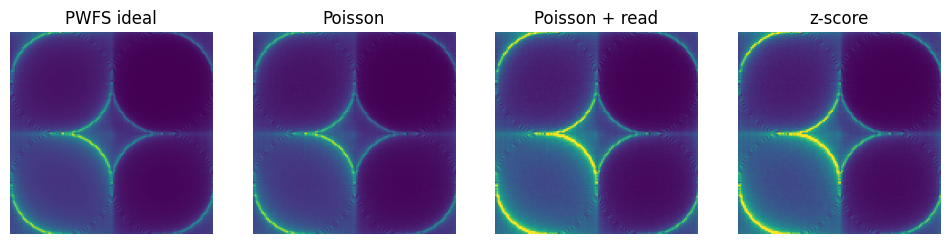

In [40]:
import torch, math
import matplotlib.pyplot as plt

# -----------------------------
# 1) Build pyramid 
# -----------------------------
def genOTF_PWFS4(N_fourier_points=128, N_points_aperture=64, separation=2.0, device='cpu'):
    beta = separation * math.pi / (N_fourier_points / N_points_aperture)
    x = torch.arange(N_fourier_points, device=device, dtype=torch.float32)
    center = N_fourier_points // 2
    fx = (x - center) * (2.0 * center / N_fourier_points)
    FX, FY = torch.meshgrid(fx, fx, indexing='ij')
    H = lambda t: torch.heaviside(t, torch.tensor(0.5, device=device))
    pym = 0j * FX
    for sx, sy in ((1,1),(1,-1),(-1,-1),(-1,1)):
        mask  = H(sx*FX) * H(sy*FY)
        phase = -beta * (sx*FX + sy*FY)
        pym   = pym + mask * torch.exp(1j * phase)
    return torch.fft.fftshift(pym).unsqueeze(0).unsqueeze(0)

# -----------------------------
# 2) Pupil and tip/tilt phase
# -----------------------------
def make_circular_pupil(N, D, device):
    y = torch.arange(N, device=device) - N//2
    x = torch.arange(N, device=device) - N//2
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= (D/2)).float()

def phase_tiptilt(N, tip_x, tip_y, D, device):
    y = torch.arange(N, device=device) - N//2
    x = torch.arange(N, device=device) - N//2
    Y, X = torch.meshgrid(y, x, indexing='ij')
    px = X / (D/2); py = Y / (D/2)
    return tip_x*px + tip_y*py

# -----------------------------
# 3) Propagation PWFS
# -----------------------------
def pwfs_forward(pupil_amp, pupil_phase, pyr_mask):
    u_pupil = pupil_amp * torch.exp(1j * pupil_phase)
    U_foc   = torch.fft.fft2(u_pupil)
    U_foc   = torch.fft.fftshift(U_foc, dim=(-2,-1))
    H_pyr   = pyr_mask[0,0]
    U_pyr   = U_foc * H_pyr
    U_pyr   = torch.fft.ifftshift(U_pyr, dim=(-2,-1))
    u_det   = torch.fft.ifft2(U_pyr)
    I_det   = u_det.real**2 + u_det.imag**2
    return I_det


device = 'cuda' if torch.cuda.is_available() else 'cpu'
N = 128; D = 64
pyr_mask = genOTF_PWFS4(N_fourier_points=N, N_points_aperture=D, separation=1.0, device=device)
pupil   = make_circular_pupil(N, D, device)
tip_x, tip_y = 0.7, -0.4
phi = phase_tiptilt(N, tip_x, tip_y, D, device)
I_pwfs = pwfs_forward(pupil, phi, pyr_mask).clamp_min(0.0)

# photon noise
photons = 3000.0
ph = torch.poisson((I_pwfs * photons).clamp_min(0.0))
after_poisson = ph / photons

# read noise
std_img = float(after_poisson.std().item()) or 1e-3
snr_db = 100.0
sigma_read = std_img / (10 ** (snr_db / 20.0))
noisy = (after_poisson + torch.randn_like(after_poisson) * sigma_read).clamp(0.0, 1.0)

# z-score (this is what we feed to the CNN)
m, s = noisy.mean(), noisy.std()
z = (noisy - m) / (s + 1e-6)

fig, axs = plt.subplots(1,4, figsize=(12,3))
axs[0].imshow(I_pwfs.cpu(), cmap='viridis'); axs[0].set_title('PWFS ideal'); axs[0].axis('off')
axs[1].imshow(after_poisson.cpu(), cmap='viridis'); axs[1].set_title('Poisson'); axs[1].axis('off')
axs[2].imshow(noisy.cpu(), cmap='viridis'); axs[2].set_title('Poisson + read'); axs[2].axis('off')
axs[3].imshow(z.cpu(), cmap='viridis'); axs[3].set_title('z-score'); axs[3].axis('off')
plt.show()


In [23]:
from torch.utils.data import Dataset, DataLoader

class PWFS_Dataset(Dataset):
    def __init__(self, n=1000, img_size=128, pupil_diam=64, separation=1.0,
                 tip_range=1.0, device='cpu', seed=0):
        self.n = n; self.N = img_size; self.D = pupil_diam
        self.tip_range = tip_range
        self.device = torch.device(device)
        torch.manual_seed(seed)
        self.otf_pyr = genOTF_PWFS4(self.N, self.D, separation, device=self.device)
        self.pupil   = make_circular_pupil(self.N, self.D, device=self.device)

    def __len__(self): return self.n

    def __getitem__(self, idx):
        tx = (torch.rand(1, device=self.device)*2 - 1) * self.tip_range
        ty = (torch.rand(1, device=self.device)*2 - 1) * self.tip_range
        phi = phase_tiptilt(self.N, tx.item(), ty.item(), self.D, device=self.device)
        I   = pwfs_forward(self.pupil, phi, self.otf_pyr)
        # normalize per-frame
        m, s = I.mean(), I.std()
        I = (I - m) / (s + 1e-6)
        x = I.unsqueeze(0).cpu()
        y = torch.tensor([tx.item(), ty.item()], dtype=torch.float32)
        return x, y


In [24]:
# Tiny CNN for tip–tilt regression
class TinyPWFSNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 2))
    def forward(self, x): return self.head(self.backbone(x))

In [ ]:
model = TinyPWFSNet().to(device)

lr = 1e-3

# You can toggle optimizers here to compare
# opt = torch.optim.SGD(model.parameters(), lr=0.1)
# opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_ds = PWFS_Dataset(n=1200, device=device)
val_ds   = PWFS_Dataset(n=200,  device=device, seed=1)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False)

loss_fn = nn.MSELoss()

def rmse(a,b): return torch.sqrt(((a-b)**2).mean())

def train_epoch(model, loader):
    model.train(); total=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        total += loss.item() * y.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval(); total=0.0; total_rmse=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        total += loss.item() * y.size(0)
        total_rmse += rmse(pred, y).item() * y.size(0)
    n = len(loader.dataset)
    return total/n, total_rmse/n

Epoch 01 | train=0.0073 | val=0.0078 | val RMSE=0.0881
Epoch 05 | train=0.0072 | val=0.0106 | val RMSE=0.1030
Epoch 10 | train=0.0048 | val=0.0050 | val RMSE=0.0709
Epoch 15 | train=0.0035 | val=0.0038 | val RMSE=0.0615
Epoch 20 | train=0.0020 | val=0.0022 | val RMSE=0.0463
Epoch 25 | train=0.0022 | val=0.0017 | val RMSE=0.0415
Epoch 30 | train=0.0026 | val=0.0019 | val RMSE=0.0435
Epoch 35 | train=0.0023 | val=0.0031 | val RMSE=0.0558
Epoch 40 | train=0.0019 | val=0.0013 | val RMSE=0.0365
Epoch 45 | train=0.0009 | val=0.0006 | val RMSE=0.0234
Epoch 50 | train=0.0014 | val=0.0005 | val RMSE=0.0218


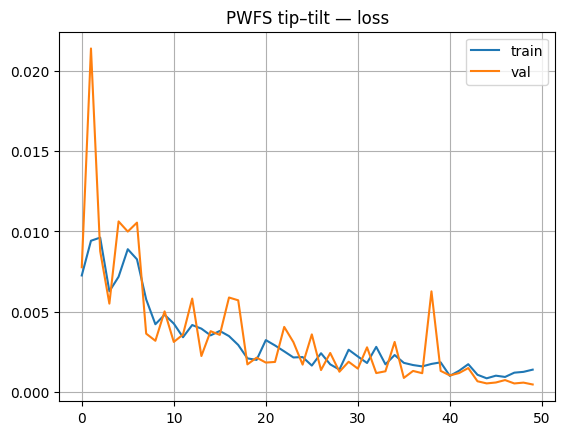

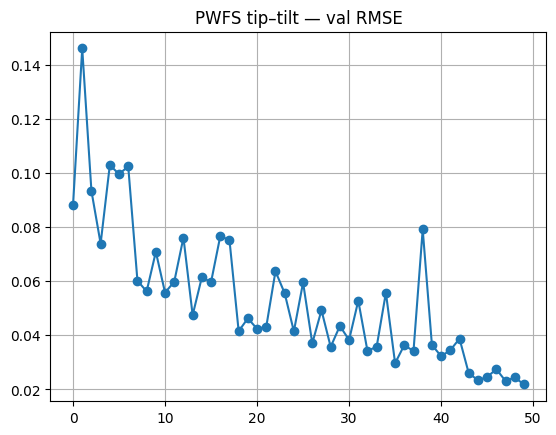

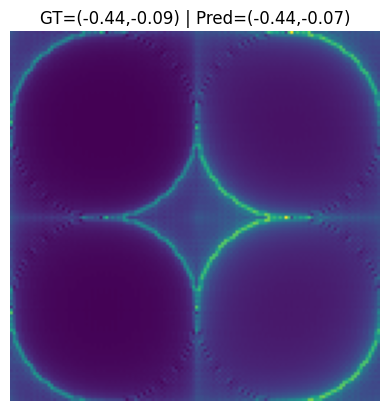

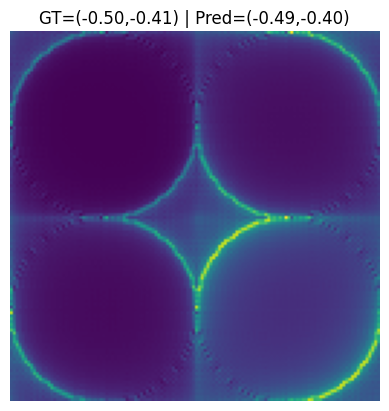

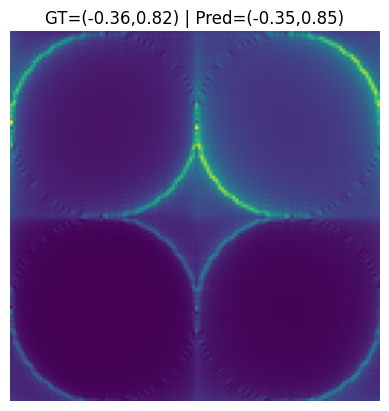

In [28]:
train_curve, val_curve, val_rmse = [], [], []

epochs = 50

for ep in range(1, epochs + 1):
    tr = train_epoch(model, train_dl)
    va, va_r = eval_epoch(model, val_dl)
    train_curve.append(tr); val_curve.append(va); val_rmse.append(va_r)
    if ep % 5 == 0 or ep == 1:
        print(f'Epoch {ep:02d} | train={tr:.4f} | val={va:.4f} | val RMSE={va_r:.4f}')

plt.figure(); plt.plot(train_curve, label='train'); plt.plot(val_curve, label='val');
plt.legend(); plt.title('PWFS tip–tilt — loss'); plt.grid(True); plt.show()

plt.figure(); plt.plot(val_rmse, marker='o'); plt.title('PWFS tip–tilt — val RMSE'); plt.grid(True); plt.show()

@torch.no_grad()
def show_preds(model, loader, k=3):
    model.eval(); shown=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        p = model(x)
        for i in range(min(k-shown, x.size(0))):
            img = x[i,0].cpu().numpy()
            plt.figure(); plt.imshow(img, cmap='viridis'); plt.axis('off')
            plt.title(f'GT=({y[i,0]:.2f},{y[i,1]:.2f}) | Pred=({p[i,0].item():.2f},{p[i,1].item():.2f})')
            plt.show()
        shown += min(k-shown, x.size(0))
        if shown >= k: break

show_preds(model, val_dl, k=3)